In [2]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from multiprocessing import cpu_count
import concurrent.futures

In [3]:
# --- Device and Seed ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
print("Device and seed setup complete.")

Device and seed setup complete.


In [4]:
# --- Parameters ---
sample_rate = 22050
n_mels = 128
hop_length = 512
fixed_width = 1280
batch_size = 32

In [5]:
# --- Data Directory ---
data_dir = "C:/Users/anura/Downloads/archive (1)/Data/genres_original"
genres = sorted(os.listdir(data_dir))
label_map = {genre: idx for idx, genre in enumerate(genres)}
print("Genre labels loaded.")

Genre labels loaded.


In [6]:
# --- Mel Transform ---
mel_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=2048,
    hop_length=hop_length,
    n_mels=n_mels
).to(device)
print("Mel spectrogram transform created.")

# --- dB Conversion ---
def to_db(mel):
    return torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=0.0)

# --- Audio to Mel ---
def wav_to_mel(filepath):
    waveform, sr = torchaudio.load(filepath)
    if sr != sample_rate:
        resample = T.Resample(orig_freq=sr, new_freq=sample_rate).to(device)
        waveform = resample(waveform.to(device))
    else:
        waveform = waveform.to(device)

    mel = mel_transform(waveform)
    mel_db = to_db(mel)
    mel_db = mel_db.squeeze(0).cpu()
    mel_db = (mel_db - mel_db.mean()) / mel_db.std()

    if np.random.rand() < 0.5:
        mel_db *= np.random.uniform(0.9, 1.1)
    if np.random.rand() < 0.3:
        mel_db += torch.randn_like(mel_db) * 0.02
    if np.random.rand() < 0.3:
        t = np.random.randint(10, 40)
        t0 = np.random.randint(0, mel_db.shape[1] - t)
        mel_db[:, t0:t0 + t] = 0

    if mel_db.shape[1] < fixed_width:
        mel_db = F.pad(mel_db, (0, fixed_width - mel_db.shape[1]))
    else:
        mel_db = mel_db[:, :fixed_width]

    return mel_db.unsqueeze(0)

Mel spectrogram transform created.


In [7]:
# --- Load Data ---
file_paths, labels = [], []
for genre in genres:
    genre_dir = os.path.join(data_dir, genre)
    for filename in os.listdir(genre_dir):
        if filename.endswith(".wav"):
            file_paths.append(os.path.join(genre_dir, filename))
            labels.append(label_map[genre])
print("File paths and labels collected.")

combined = list(zip(file_paths, labels))
np.random.shuffle(combined)
file_paths, labels = zip(*combined)
print("Data shuffled.")



File paths and labels collected.
Data shuffled.


In [8]:
# --- Parallel Processing of Spectrograms ---
def process_file(args):
    filepath, label = args
    try:
        mel = wav_to_mel(filepath)
        return mel, label
    except:
        return None

mel_specs, targets = [], []
with concurrent.futures.ThreadPoolExecutor(max_workers=cpu_count()) as executor:
    for result in tqdm(executor.map(process_file, zip(file_paths, labels)), total=len(file_paths)):
        if result:
            mel, label = result
            mel_specs.append(mel)
            targets.append(label)
print("Mel-spectrograms computed and augmented.")

X = torch.stack(mel_specs).float()
y = torch.tensor(targets)
print("Data tensors prepared.")

train_size = int(0.85 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]
print("Data split into train and validation sets.")

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=batch_size, pin_memory=True)
print("Data loaders created.")

100%|██████████| 1000/1000 [00:01<00:00, 643.94it/s]


Mel-spectrograms computed and augmented.
Data tensors prepared.
Data split into train and validation sets.
Data loaders created.


In [9]:
# --- Model ---
conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1).to(device)
bn1 = nn.BatchNorm2d(64).to(device)
conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device)
bn2 = nn.BatchNorm2d(128).to(device)
conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1).to(device)
bn3 = nn.BatchNorm2d(256).to(device)

print("Convolutional layers initialized.")

grulayer = nn.GRU(input_size=256 * 16, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True).to(device)
fc1 = nn.Linear(128 * 2, 128).to(device)
fc2 = nn.Linear(128, 10).to(device)
dropout = nn.Dropout(0.5).to(device)
print("GRU and fully connected layers initialized.")

params = list(conv1.parameters()) + list(bn1.parameters()) + list(conv2.parameters()) + list(bn2.parameters()) + \
         list(conv3.parameters()) + list(bn3.parameters()) + list(grulayer.parameters()) + \
         list(fc1.parameters()) + list(fc2.parameters()) + list(dropout.parameters())

optimizer = torch.optim.Adam(params, lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()
print("Optimizer and loss function ready.")

# --- Forward ---
def forward(x):
    x = F.relu(bn1(conv1(x)))
    x = F.max_pool2d(x, 2)
    x = F.relu(bn2(conv2(x)))
    x = F.max_pool2d(x, 2)
    x = F.relu(bn3(conv3(x)))
    x = F.max_pool2d(x, 2)
    x = x.permute(0, 3, 1, 2).flatten(2)
    _, h = grulayer(x)
    h = torch.cat((h[-2], h[-1]), dim=1)
    x = dropout(F.relu(fc1(h)))
    return fc2(x)

Convolutional layers initialized.
GRU and fully connected layers initialized.
Optimizer and loss function ready.


In [10]:
# --- Training ---
best_f1 = 0
patience = 5
epochs_no_improve = 0
print("Starting training loop...")

for epoch in range(50):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds = forward(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            preds = forward(xb)
            preds = torch.argmax(preds, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Acc: {acc:.4f}, F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        torch.save({
            'conv1': conv1.state_dict(),
            'conv2': conv2.state_dict(),
            'conv3': conv3.state_dict(),
            'bn1': bn1.state_dict(),
            'bn2': bn2.state_dict(),
            'bn3': bn3.state_dict(),
            'gru': grulayer.state_dict(),
            'fc1': fc1.state_dict(),
            'fc2': fc2.state_dict(),
        }, "best_gtzan_crnn.pth")
        print("Saved best model!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

Starting training loop...
Epoch 1, Loss: 57.8094, Val Acc: 0.3133, F1: 0.2571
Saved best model!
Epoch 2, Loss: 50.0785, Val Acc: 0.3467, F1: 0.3052
Saved best model!
Epoch 3, Loss: 43.6576, Val Acc: 0.3867, F1: 0.3477
Saved best model!
Epoch 4, Loss: 40.0113, Val Acc: 0.5467, F1: 0.5222
Saved best model!
Epoch 5, Loss: 33.8088, Val Acc: 0.5333, F1: 0.5284
Saved best model!
Epoch 6, Loss: 29.4405, Val Acc: 0.5800, F1: 0.5493
Saved best model!
Epoch 7, Loss: 26.7263, Val Acc: 0.7000, F1: 0.7058
Saved best model!
Epoch 8, Loss: 22.4743, Val Acc: 0.6200, F1: 0.5974
Epoch 9, Loss: 20.0027, Val Acc: 0.6467, F1: 0.6115
Epoch 10, Loss: 16.4388, Val Acc: 0.7333, F1: 0.7207
Saved best model!
Epoch 11, Loss: 12.3130, Val Acc: 0.7333, F1: 0.7189
Epoch 12, Loss: 10.4625, Val Acc: 0.7800, F1: 0.7742
Saved best model!
Epoch 13, Loss: 9.2001, Val Acc: 0.7133, F1: 0.6969
Epoch 14, Loss: 6.6861, Val Acc: 0.7467, F1: 0.7406
Epoch 15, Loss: 6.1464, Val Acc: 0.7800, F1: 0.7761
Saved best model!
Epoch 16, L

Evaluating model and generating confusion matrix...
Final Accuracy: 0.8067
Final F1 Score (macro): 0.8042


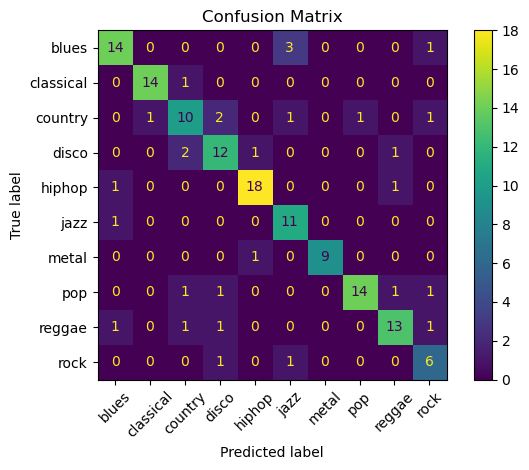

Confusion matrix displayed.


In [13]:
# --- Evaluation / Confusion Matrix ---
print("Evaluating model and generating confusion matrix...")

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Final Accuracy: {acc:.4f}")
print(f"Final F1 Score (macro): {f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print("Confusion matrix displayed.")
